In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/users-vs-bots-classification/bots_vs_users.csv


In [2]:
#Import libraries
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

In [3]:
import kagglehub



df = pd.read_csv('/kaggle/input/users-vs-bots-classification/bots_vs_users.csv')

In [4]:
def prepare_train(df):
    #Replace words which mean 'Nan'
    df = df.replace('Unknown', np.nan)
    #drop features that have less information than 50%
    df = df.loc[:, df.isna().mean() <= 0.5]
    #NaN-target encoding, replace NaN by target
    df = df.apply(lambda col: col.fillna(df['target']) if col.name != 'target' else col)
    #Many features is non-numeric, but contains only int or float -> convert them into numeric
    for col in df.columns:
        converted = pd.to_numeric(df[col], errors='coerce')
        if not converted.isna().any():
            df[col] = converted
    #categorial features list for catboost
    cat_cols = df.select_dtypes(include='object').columns[0]
    #transform categorial features from 'object' to 'category' type 
    df[cat_cols] = df[cat_cols].astype('category')
    return df, cat_cols  

In [5]:
#Apply preparing function
df, cat_cols = prepare_train(df)

In [6]:
df

,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,...,has_nickname,has_mobile,all_posts_visible,audio_available,can_add_as_friend,can_invite_to_group,is_blacklisted,is_verified,is_confirmed,city
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5869,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Saint Petersburg
5870,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Saint Petersburg
5871,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Saint Petersburg
5872,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,Moscow


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


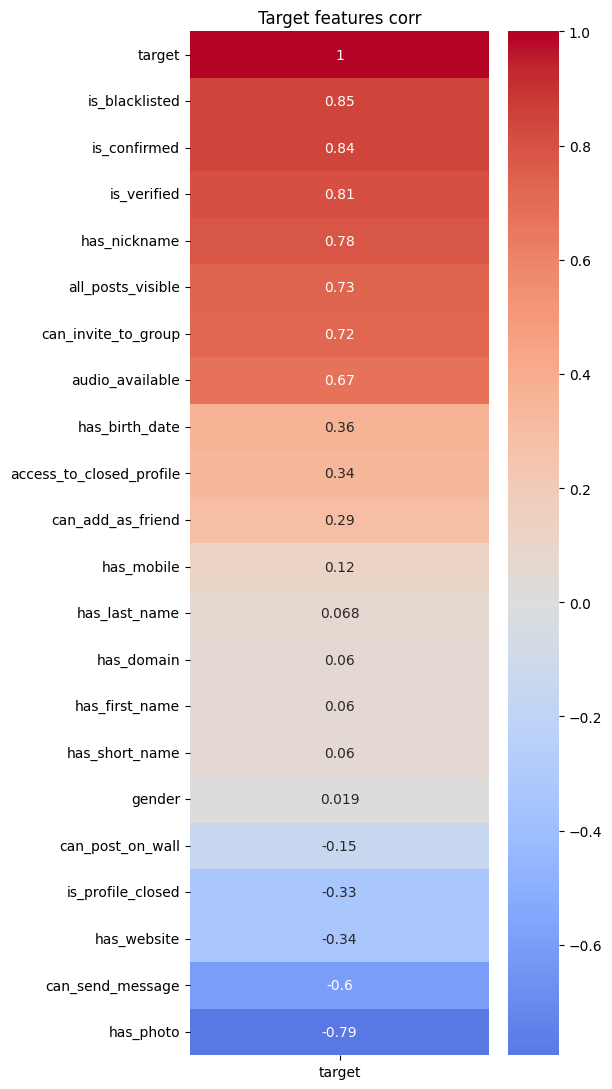

In [7]:
#Correlation matrix
corr = df.corr(numeric_only=True)
target_corr = corr[['target']].sort_values(by='target', ascending=False)
plt.figure(figsize=(6, len(target_corr) * 0.5))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0)

plt.title("Target features corr")
plt.tight_layout()
plt.show()

In [8]:
#Target and train arrays
X = df.drop('target', axis=1)
y = df['target']

In [9]:
#Checking class-balance
y.value_counts()

target
1    2937
0    2937
Name: count, dtype: int64

In [10]:
#Splitting train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  
)

In [11]:
#Creating and training CatBoost model
model = CatBoostClassifier(
    iterations=100,
    eval_metric='Accuracy',  
    verbose=0
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    cat_features=cat_cols.split(),
    use_best_model=False,
    verbose=0
)

#information about accuracy on each epoch for plots
evals_result = model.evals_result_

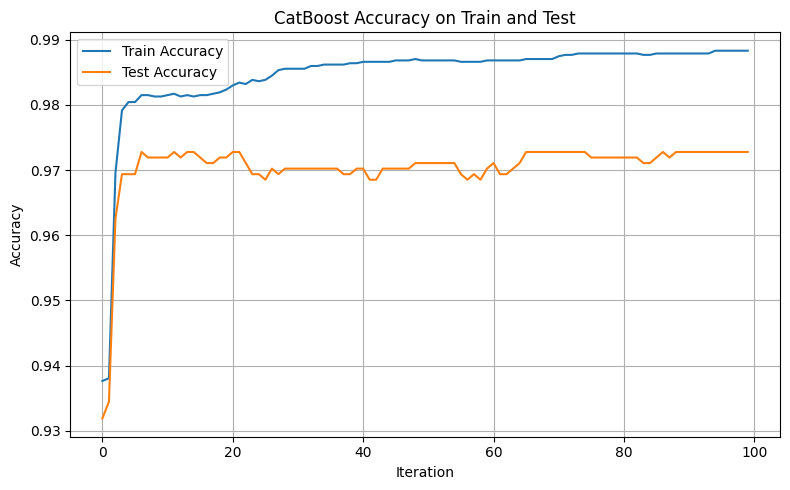

In [12]:
#Accuracy on train and test plot
plt.figure(figsize=(8, 5))
plt.plot(evals_result['learn']['Accuracy'], label='Train Accuracy')
plt.plot(evals_result['validation']['Accuracy'], label='Test Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('CatBoost Accuracy on Train and Test')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [13]:
#Scoring accuracy on prediction X_test
y_pred = model.predict(X_test)

#Alternative form of accuracy on 0 / 1 classification
accuracy = y_pred.sum() / y_test.sum()
print(f"accuracy is ', {accuracy:.4f}")

accuracy is ', 0.9796
